# Incidence of Breast Cancer Around the World
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
Breast cancer, a complex and multifaceted disease, exhibits varying incidence rates globally due to a multitude of factors, including genetic predisposition, environmental influences, and socioeconomic disparities. As we embark on our investigation, our objective is to delve into the intricacies of breast cancer data sets, meticulously analyzing trends, patterns, and correlations to glean valuable insights. By scrutinizing this data with precision and rigor, we aim to contribute to the collective understanding of breast cancer epidemiology and advance efforts in prevention, early detection, and treatment strategies


### Dataset Description 
The data we would be using to explore the incidence of breast cancer around the world is a public data set and it is available for dowload on  [Gap Minder](https://gapminder.org/data/). However, there was no comprehensive data detailing the countries and their continents on [Gap Minder](https://gapminder.org/data/) which was why the `continents'` data set was sourced from [Our World in Data](https://ourworldindata.org/grapher/continents-according-to-our-world-in-data)

### Data Dictionary

- ` country`: The countries of the world

- `code`: The country code

- `continent`: The continents of the world

- `year` : The year for each record
- `bc_death` : Total number of female deaths due to breast cancer
- `bc_death_in_thousand`: number of deats due to breast cancer in 100,000 female residents
- `bc_newcase_in_thousand`: Number of new cases of breast cancer in 100,000 female residents during the year
- `bc_newcase`: Total number of female breast cancer new cases
- `hdi`: Humman development Index

### Questions for Analysis
1. What is the prevalance rate of Breast cancer over the years?
2. What is the general trend displayed by all continents concerning the incidence of breast cancer?
3. Is there a difference between the incidence of breast canncer between developing countries and the develped world?

In [1]:
#import all the neccessary packages and styles for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

%matplotlib inline
plt.style.use('default')

<a id='wrangling'></a>
## Data Wrangling
The data was extracted from Gapminder and our wolrd in data as previously referenced. for this analysis each data set have been downloaded locally. 
Majority of the columns in the combined datasets are numeric and as such be treated as numbers.
In some columns, "B","M" and "K" meaning billion, million and thousand respectively as unit of measurements. The will be thoroughly converted to their base numeric equivalence.

In [2]:
# exract data from the local machine
dataset=[
    "C:/Users/Oluwasola.Aduewa/Downloads/breast_cancer_deaths_per_100000_women.csv",
    "C:/Users/Oluwasola.Aduewa/Downloads/breast_cancer_new_cases_per_100000_women.csv",
    "C:/Users/Oluwasola.Aduewa/Downloads/breast_cancer_number_of_female_deaths.csv",
    "C:/Users/Oluwasola.Aduewa/Downloads/breast_cancer_number_of_new_female_cases.csv",
    "C:/Users/Oluwasola.Aduewa/Downloads/continents-according-to-our-world-in-data.csv",
    "C:/Users/Oluwasola.Aduewa/Downloads/hdi_human_development_index.csv",
    "C:/Users/Oluwasola.Aduewa/Downloads/pop.csv",
    # "C:/Users/Oluwasola.Aduewa/Downloads/breast_cancer_deaths_per_100000_women.csv"
]

In [3]:
# the function reads csv files according to its index
def load(data,num):
    """reads all the csv files"""
    return pd.read_csv(data[num])

In [4]:
#Load all the dataset
bc_death_th=load(dataset,0) 
bc_newcase_th=load(dataset,1)   
bc_death=load(dataset,2)
bc_newcase=load(dataset,3) 
geo=load(dataset,4) 
hdi=load(dataset,5) 
pop=load(dataset,6) 


### The need to transpose
Majority of all the datset are in wide format as shown above. Hence the need to transpose them. In pandas, the melt() function does the trick. 

In [5]:
#create a function that performs the melts the operation 
def transpose(df,var):
    df=pd.melt(df, id_vars='country', var_name='year', value_name=var)
    return(df)

#*********************************************************************#
#melt the dataset accordingly
bc_death_th=transpose(bc_death_th,"bc_death_in_thousand")
bc_newcase_th=transpose(bc_newcase_th,"bc_newcase_in_thousand")
bc_death=transpose(bc_death,"bc_death")
bc_newcase=transpose(bc_newcase,"bc_newcase")
# geo=transpose(investment_df,'region')
hdi=transpose(hdi,"hdi")
pop=transpose(pop,"population")

In [6]:
geo.columns=['country','code','year','continent']
geo.head()

country      code  year continent
0               Abkhazia  OWID_ABK  2015      Asia
1            Afghanistan       AFG  2015      Asia
2  Akrotiri and Dhekelia  OWID_AKD  2015      Asia
3                Albania       ALB  2015    Europe
4                Algeria       DZA  2015    Africa

### Merge all dataset together
All the data read into pandas will be merged into a single dataframe using outerr join."

   __similarities in the datase
- The other dataset apart from `geo` will be merged first and separately on the country and year keys.
-  The resulting dataframe will then be merged with the `geo` dataframee others

In [7]:
data_set=[bc_death,bc_death_th,bc_newcase_th,bc_newcase,hdi]
#create a function that merges all other dataset at once
def merge(others,df):
    for i,v in enumerate(others):
        df=pd.merge(df,others[i],on=['country','year'])
    return df



In [8]:
from functools import reduce

if len(data_set) > 1:
    # Define the function to merge two DataFrames on common keys
    def merge_dataframes(left, right):
        return pd.merge(left, right, on=['country', 'year'],how='outer')

    # Use reduce to merge all DataFrames in the list
    merged_df = reduce(merge_dataframes, data_set)
else:
    merged_df = data_set[0]  # If there's only one DataFrame, no need to merge

# Now merged_df contains the result of joining all DataFrames on 'country' and 'year'


In [9]:
df=merged_df.copy()

In [10]:
def convert_population(value):
    if pd.isnull(value):
        return np.nan  # Return NaN if the value is NaN
    elif isinstance(value, (int, float)):
        return int(value)  # Convert numeric values to integer directly
    elif 'B' in value:
        return int(float(value[:-1]) * 1e9)  # Convert billions to integer
    elif 'M' in value:
        return int(float(value[:-1]) * 1e6)  # Convert millions to integer
    elif 'k' in value:
        return int(float(value[:-1]) * 1e3)  # Convert thousands to integer
    else:
        return int(value)  # Convert other values directly to integer


# Assuming df is your DataFrame and 'population' is the column containing the values
# df['population'] = df['population'].apply(convert_population)


In [11]:
df.head()

country  year bc_death  bc_death_in_thousand  bc_newcase_in_thousand  \
0  Afghanistan  1990      501                  13.9                    17.1   
1       Angola  1990      308                  14.0                    16.2   
2      Albania  1990      110                   NaN                    18.8   
3      Andorra  1990     5.15                  20.0                    62.8   
4          UAE  1990     45.2                  25.5                    40.8   

  bc_newcase    hdi  
0        644  0.273  
1        383    NaN  
2        221  0.647  
3       17.4    NaN  
4       86.5  0.728

In [12]:
df=df.merge(geo[['country','code','continent']],on='country',how='left')

In [13]:
df[df['continent'].isnull()].country.unique()

array(['UAE', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Cook Is',
       'Czech Republic', 'Micronesia, Fed. Sts.', 'UK', 'Kyrgyz Republic',
       'St. Kitts and Nevis', 'Lao', 'St. Lucia', 'Slovak Republic',
       'Timor-Leste', 'USA', 'St. Vincent and the Grenadines',
       'Virgin Islands (U.S.)', 'Hong Kong, China'], dtype=object)

### Fill empty cells with the Names of Continents and code of their respective countries for every column that NaN is present

In [14]:
import pandas as pd

# Assuming df is your DataFrame containing the 'country' and 'continent' columns
# Define a dictionary mapping countries to continents
country_to_continent = {
    'UAE': 'Asia',
    'Congo, Dem. Rep.': 'Africa',
    'Congo, Rep.': 'Africa',
    'Cook Is': 'Oceania',
    'Czech Republic': 'Europe',
    'Micronesia, Fed. Sts.': 'Oceania',
    'UK': 'Europe',
    'Kyrgyz Republic': 'Asia',
    'St. Kitts and Nevis': 'North America',
    'Lao': 'Asia',
    'St. Lucia': 'North America',
    'Slovak Republic': 'Europe',
    'Timor-Leste': 'Asia',
    'USA': 'North America',
    'St. Vincent and the Grenadines': 'North America',
    'Virgin Islands (U.S.)': 'North America',
    'Hong Kong, China': 'Asia',
    'Holy See': 'Europe'
}

# Fill missing values in 'continent' column based on 'country' column
df['continent'] = df['continent'].fillna(df['country'].map(country_to_continent))



In [15]:
# Define a dictionary mapping countries to their codes
country_to_code = {
    'UAE': 'AE',
    'Congo, Dem. Rep.': 'CD',
    'Congo, Rep.': 'CG',
    'Cook Is': 'CK',
    'Czech Republic': 'CZ',
    'Micronesia, Fed. Sts.': 'FM',
    'UK': 'GB',
    'Kyrgyz Republic': 'KG',
    'St. Kitts and Nevis': 'KN',
    'Lao': 'LA',
    'St. Lucia': 'LC',
    'Slovak Republic': 'SK',
    'Timor-Leste': 'TL',
    'USA': 'US',
    'St. Vincent and the Grenadines': 'VC',
    'Virgin Islands (U.S.)': 'VI',
    'Hong Kong, China': 'HK',
    'Holy See': 'VA'
}

# Fill missing values in 'code' column based on 'country' column
df['code'] = df['code'].fillna(df['country'].map(country_to_code))


In [16]:
df.head()

country  year bc_death  bc_death_in_thousand  bc_newcase_in_thousand  \
0  Afghanistan  1990      501                  13.9                    17.1   
1       Angola  1990      308                  14.0                    16.2   
2      Albania  1990      110                   NaN                    18.8   
3      Andorra  1990     5.15                  20.0                    62.8   
4          UAE  1990     45.2                  25.5                    40.8   

  bc_newcase    hdi code continent  
0        644  0.273  AFG      Asia  
1        383    NaN  AGO    Africa  
2        221  0.647  ALB    Europe  
3       17.4    NaN  AND    Europe  
4       86.5  0.728   AE      Asia

In [17]:
def convert_to_float(value):
    if pd.isnull(value):
        return value  # Return NaN if the value is NaN
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6  # Convert millions to float
    elif 'k' in value:
        return float(value.replace('k', '')) * 1e3  # Convert thousands to float
    else:
        return float(value)  # Convert other values to float

# Assuming df is your DataFrame and 'bc_death' is the column containing the values
df['bc_death'] = df['bc_death'].apply(convert_to_float)
df['bc_newcase'] = df['bc_newcase'].apply(convert_to_float)

In [18]:
# df['population'] = pd.to_numeric(df['population'], errors='coerce', downcast='integer')
df['year'] = pd.to_numeric(df['year'], errors='coerce', downcast='integer')
# df['population'] = pd.to_numeric(df['population'], errors='coerce', downcast='integer')


<a id='eda'></a>
# Exploratory Data Analysis

### Viz A
***
<b>Breast Cancer Deaths by continents: Attempts to show the yearly trend of female mortality due to breast cancer across the continents</b>

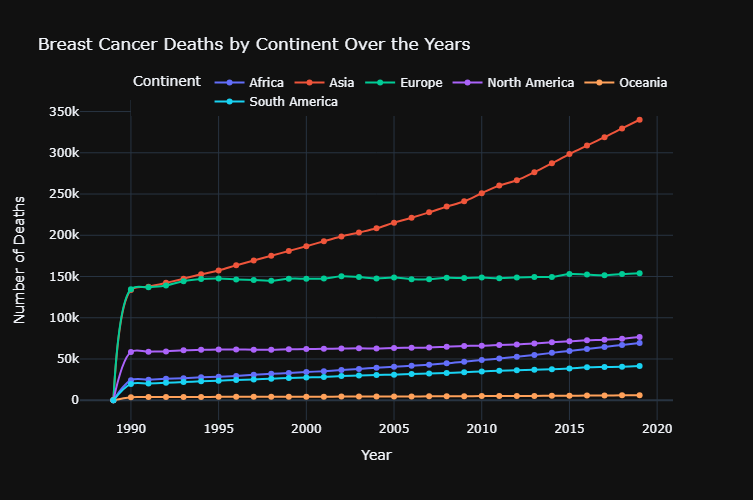

In [19]:
import plotly.express as px

# Assuming df_agg is your aggregated DataFrame with columns 'continent', 'year', and 'bc_death'
df_agg = df.groupby(['continent', 'year'], as_index=False)['bc_death'].sum()
# Filter the DataFrame to include only data from 1989 onwards
df_filtered = df_agg[(df_agg['year'] >= 1989) & (df_agg['year'] < 2020)]

# Plot line plots for each continent
fig = px.line(df_filtered, x='year', y='bc_death', color='continent', 
              title='Breast Cancer Deaths by Continent Over the Years',
              line_shape='spline',  # Use spline interpolation for smoother curves
              labels={'year': 'Year', 'bc_death': 'Number of Deaths'},
              width=800,  # Set width of the plot
              height=500,  # Set height of the plot
              template='plotly_dark'  # Use dark theme
             )

# Customize legend
fig.update_traces(mode='lines+markers')  # Show markers along with lines
fig.update_layout(legend=dict(title='Continent', orientation='h', yanchor='top', y=1.1, xanchor='right', x=1))

# Show the plot
fig.show()


>#### Notable Insight
>The data, spanning from 1991, reveals a notable divergence in breast cancer mortality trends between Europe and Asia. While both regions commenced at similar levels, Asia quickly surged ahead, outpacing Europe within just two years and continuing its upward trajectory until 2021. Interestingly, mortality rates in Europe have remained relatively stable since 1992. Asia, on the other hand, has consistently recorded the highest mortality rates, followed by Europe.

>Additionally, all other continents have witnessed an increase in female deaths attributed to breast cancer. The early surge in mortality rates across these regions may reflect a knowledge gap in understanding the causes of breast cancer, coupled with the absence of early detection programs and awareness initiatives targeting the female demographic. However, the subsequent stabilization in mortality trends suggests a positive shift, possibly indicative of heightened awareness and the implementation of advanced early detection methods and diagnostic approaches for breast cancer.
>
><b>Up Next:<b>
>
>We will delve deeper into individual continents to identify countries with alarming rates of breast cancer.

Viz B
***
In this instance, we aim to visualize breast cancer-related deaths on a world map, where the intensity of color signifies the degree of mortality.

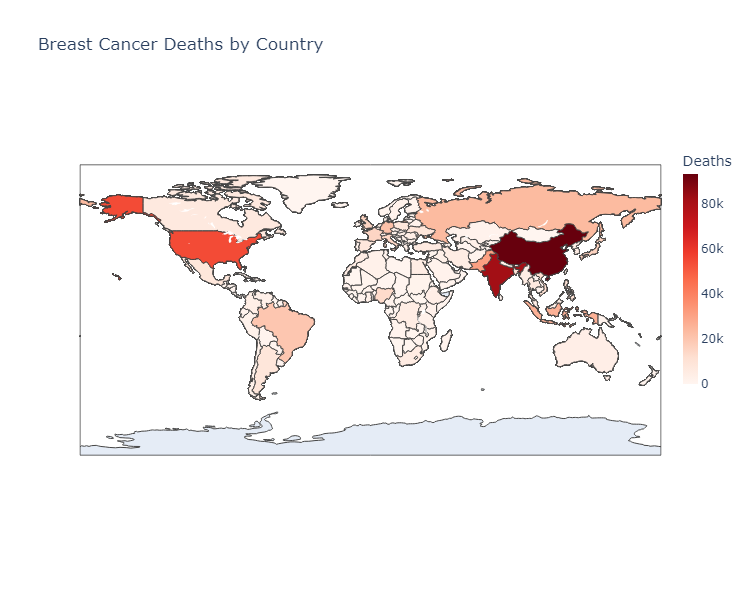

In [20]:
fig = px.choropleth(df, 
                    locations="country", 
                    locationmode="country names",
                    color="bc_death",
                    hover_name="country",
                    color_continuous_scale='Reds',
                    title="Breast Cancer Deaths by Country",
                    labels={"bc_death": "Deaths"}
                   )

# fig.update_layout(geo=dict(showcoastlines=True))
# Increase the size of the plot
fig.update_layout(
    geo=dict(showcoastlines=True),
    height=600,  # Set height
    width=700    # Set width
)
# Customize the color bar
fig.update_coloraxes(colorbar=dict(thickness=15, len=0.6, yanchor='top', y=0.9))
fig.show()


>### Notable Insight
>The map highlights China as having the highest breast cancer mortality, closely followed by India in the Asian continent. In the Americas, the United States leads the list, trailed by Brazil. In Europe, Russia ranks highest. Notably, there appears to be a correlation between mortality rates and population density, as these countries are densely populated, thus reflecting higher breast cancer mortality rates
>
>However, it's essential to consider that our metric solely relies on the absolute number of deaths, which may inadvertently overshadow regions with lower population density. To address this, we will further analyze the number of breast cancer deaths per 100,000 female residents. This approach will provide a more accurate representation of breast cancer mortality rates, accounting for variations in population density across regions.

Viz C
***
Aim to visualize the number of breast cancer deaths per 100,000 female residents.

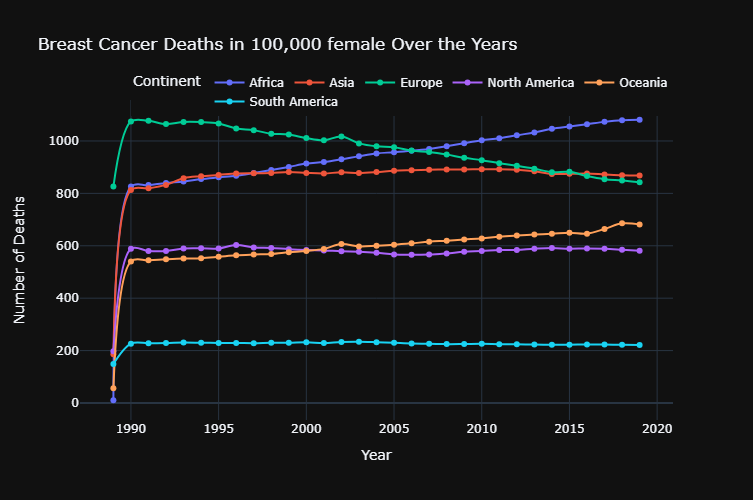

In [21]:
import plotly.express as px
agg=df.groupby(['continent', 'year'], as_index=False)['bc_death_in_thousand'].sum()
# Assuming df_agg is your aggregated DataFrame with columns 'continent', 'year', and 'bc_death'
df_agg = agg.copy()
# Filter the DataFrame to include only data from 1989 onwards
df_filtered = df_agg[(df_agg['year'] >= 1989) & (df_agg['year'] < 2020)]

# Plot line plots for each continent
fig = px.line(df_filtered, x='year', y='bc_death_in_thousand', color='continent', 
              title='Breast Cancer Deaths in 100,000 female Over the Years',
              line_shape='spline',  # Use spline interpolation for smoother curves
              labels={'year': 'Year', 'bc_death_in_thousand': 'Number of Deaths'},
              width=800,  # Set width of the plot
              height=500,  # Set height of the plot
              template='plotly_dark'  # Use dark theme
             )

# Customize legend
fig.update_traces(mode='lines+markers')  # Show markers along with lines
fig.update_layout(legend=dict(title='Continent', orientation='h', yanchor='top', y=1.1, xanchor='right', x=1))

# Show the plot
fig.show()


#### Notable Insight
>Contrary to the total number of deaths, when examining breast cancer mortality rates per 100,000 females, a different picture emerges. Europe held the highest mortality rates from 1990 to 2005 even though it has been decliningsince 1992. However, in 2007, Africa surpassed Europe, becoming the region with the highest mortality rates per 100,000 women. The initial upward trends witnessed across continents align with our earlier observations regarding knowledge gaps in breast cancer causes, diagnosis, and awareness programs.
>
>Notably, densely populated regions experienced an initial spike in mortality rates followed by a decline. Conversely, Africa has maintained an upward trend since 1990, highlighting ongoing challenges in addressing breast cancer-related issues. Similarly, Oceania has also shown a consistent increase in mortality rates. These trends emphasize the multifaceted nature of breast cancer dynamics, influenced by factors such as population density, awareness initiatives, and healthcare infrastructure.

Viz D
***

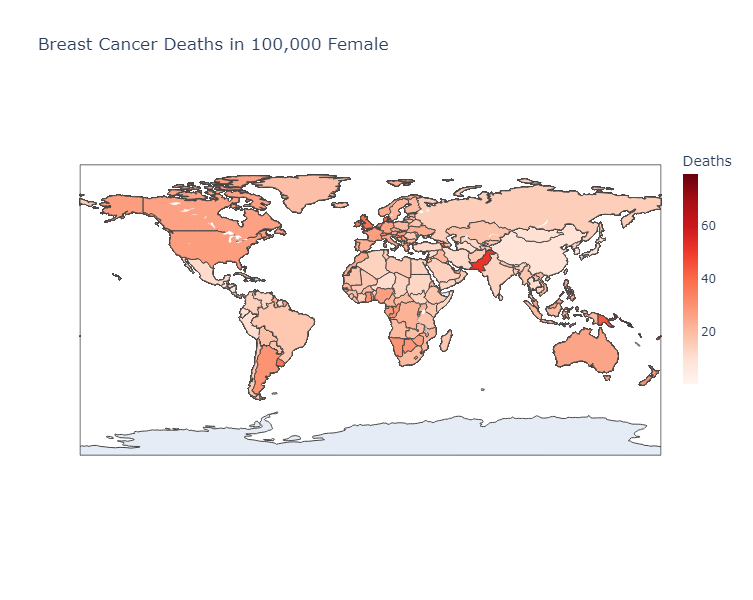

In [22]:
fig = px.choropleth(df, 
                    locations="country", 
                    locationmode="country names",
                    color="bc_death_in_thousand",
                    hover_name="country",
                    color_continuous_scale='Reds',
                    title="Breast Cancer Deaths in 100,000 Female",
                    labels={"bc_death_in_thousand": "Deaths"}
                   )

# fig.update_layout(geo=dict(showcoastlines=True))
# Increase the size of the plot
fig.update_layout(
    geo=dict(showcoastlines=True),
    height=600,  # Set height
    width=700    # Set width
)
# Customize the color bar
fig.update_coloraxes(colorbar=dict(thickness=15, len=0.6, yanchor='top', y=0.9))
fig.show()


>The map shows overally the number of deaths due to breast cancer in 100,000 women. Overall, pakistan recorded the highest deaths on aggregate
>
>We will go ahead to explore likely relationships between the variables

In [55]:
matrix=df[['bc_death', 'bc_death_in_thousand', 'bc_newcase_in_thousand', 'bc_newcase', 'hdi']].corr().round(2)
matrix

bc_death  bc_death_in_thousand  \
bc_death                    1.00                 -0.05   
bc_death_in_thousand       -0.05                  1.00   
bc_newcase_in_thousand      0.10                  0.64   
bc_newcase                  0.93                 -0.06   
hdi                         0.13                  0.22   

                        bc_newcase_in_thousand  bc_newcase   hdi  
bc_death                                  0.10        0.93  0.13  
bc_death_in_thousand                      0.64       -0.06  0.22  
bc_newcase_in_thousand                    1.00        0.17  0.76  
bc_newcase                                0.17        1.00  0.19  
hdi                                       0.76        0.19  1.00

>### Notable Insight
>While we might expect cancer-related deaths and new cases to be somewhat correlated, our analysis reveals a strong link between a country's Human Development Index (HDI) and the number of breast cancer deaths per 100,000 females. A high HDI appears to be closely associated with higher breast cancer mortality rates, suggesting that factors related to human development may play a significant role in determining breast cancer outcomes.
>
>Although statistical numbers provide valuable insights, visualizations offer a more intuitive way to comprehend the relationship. We will go ahead to use scatter plots to vividly illustrate how breast cancer (in 100,000 females) mortality rates fluctuate with changes in the Human Development Index (HDI)

Viz E
***


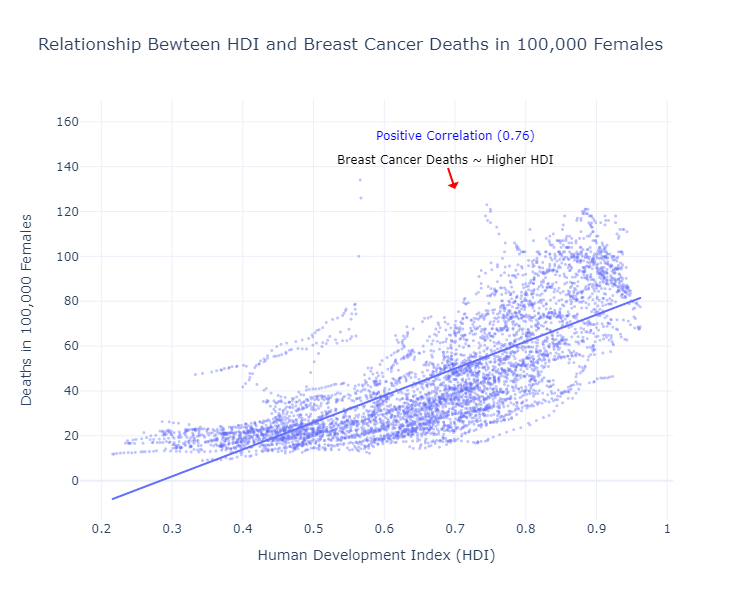

In [103]:
import plotly.express as px

# Assuming df is your DataFrame with columns 'hdi' and 'bc_death'

# Plot scatter plot of HDI vs. breast cancer deaths with trendline
fig = px.scatter(df, x='hdi', y='bc_newcase_in_thousand', 
                 title='Relationship Bewteen HDI and Breast Cancer Deaths in 100,000 Females',
                 labels={'hdi': 'Human Development Index (HDI)', 'bc_newcase_in_thousand': 'Deaths in 100,000 Females'},
                 trendline='ols',  # Add trendline using Ordinary Least Squares method
                 width=800,  # Set width of the plot
                 height=600,  # Set height of the plot
                 template='plotly_white'  # Use white background
                )

# Customize trendline and annotations
fig.update_traces(marker=dict(size=3, opacity=0.4),
                  selector=dict(mode='markers'))
fig.add_annotation(x=0.7, y=154, text="Positive Correlation (0.76)", showarrow=False, font=dict(size=12, color='blue'), align='left')
fig.add_annotation(x=0.7, y=130, text="Breast Cancer Deaths ~ Higher HDI", showarrow=True, arrowhead=1, arrowwidth=2, arrowcolor='red', font=dict(size=12, color='black'), align='left')

# Show the plot
fig.show()


>#### Notable Insight
>
>The correlation between a country's Human Development Index (HDI) and breast cancer mortality rates indicates a statistical relationship, but it doesn't necessarily imply a direct causation. While countries with higher HDI may indeed have more advanced technology and better access to healthcare services, leading to improved cancer diagnosis and treatment options, other factors may also contribute to higher mortality rates.
>
>For instance, lifestyle factors, such as diet, exercise, and access to preventive care, can influence breast cancer outcomes. Additionally, socioeconomic disparities, including income inequality and access to education, can impact healthcare access and utilization, affecting mortality rate
>
>Therefore, while a higher HDI may correlate with better healthcare resources and technology, other factors can still contribute to varying mortality rates among countries. Understanding these complex interactions can help inform public health policies and interventions aimed at reducing breast cancer mortality rates globally.

# Conclusion

>In light of the insights gleaned, it becomes apparent that breast cancer mortality rates per 100,000 females present a nuanced perspective compared to total death numbers. The examination of breast cancer mortality rates per 100,000 females unveils a distinct narrative from total death figures. Despite Europe holding the highest mortality rates from 1990 to 2005, a declining trend has been evident since 1992. In a surprising turn, Africa surpassed Europe in 2007, emerging with the highest mortality rates per 100,000 women. These shifts align with the identified knowledge gaps in breast cancer causes, diagnosis, and awareness programs.
>Moreover, the strong positive correlation between breast cancer mortality rates and the Human Development Index (HDI) underscores the complex interplay between socioeconomic factors and healthcare outcomes. While densely populated regions initially experienced mortality spikes followed by declines, Africa has sustained an upward trend since 1990, signaling persistent challenges in addressing breast cancer-related issues. Similarly, Oceania has exhibited a consistent increase in mortality rate
>
>These findings underscore the multifaceted nature of breast cancer dynamics, influenced by factors such as population density, awareness initiatives, and healthcare infrastructure. As we navigate these complexities, comprehensive approaches addressing medical, social, and economic determinants are crucial in reducing breast cancer mortality rates and ensuring equitable access to healthcare for all individuals.

In [104]:
# import plotly.express as px
# agg=df.groupby(['continent', 'year'], as_index=False)['bc_newcase'].sum()
# # Assuming df_agg is your aggregated DataFrame with columns 'continent', 'year', and 'bc_death'
# df_agg = agg.copy()
# # Filter the DataFrame to include only data from 1989 onwards
# df_filtered = df_agg[(df_agg['year'] >= 1989) & (df_agg['year'] < 2020)]

# # Plot line plots for each continent
# fig = px.line(df_filtered, x='year', y='bc_newcase', color='continent', 
#               title='New Cases of Breast Cancer by Continent Over the Years',
#               line_shape='spline',  # Use spline interpolation for smoother curves
#               labels={'year': 'Year', 'bc_death': 'Number of Deaths'},
#               width=800,  # Set width of the plot
#               height=500,  # Set height of the plot
#               template='plotly_dark'  # Use dark theme
#              )

# # Customize legend
# fig.update_traces(mode='lines+markers')  # Show markers along with lines
# fig.update_layout(legend=dict(title='Continent', orientation='h', yanchor='top', y=1.1, xanchor='right', x=1))

# # Show the plot
# fig.show()


In [24]:
# import plotly.express as px

# # Assuming df_agg is your aggregated DataFrame with columns 'continent', 'year', and 'bc_death'

# # Filter the DataFrame to include only data from 1989 onwards
# df_filtered = df_agg[(df_agg['year'] >= 1989) & (df_agg['year'] < 2020)]

# # Plot line plots for each continent
# fig = px.line(df_filtered, x='year', y='bc_death', color='continent', 
#               title='Breast Cancer Deaths by Continent Over the Years',
#               line_shape='spline',  # Use spline interpolation for smoother curves
#               labels={'year': 'Year', 'bc_death': 'Number of Deaths'},
#               width=800,  # Set width of the plot
#               height=400,  # Set height of the plot
#               template='plotly_white'  # Use white background
#              )

# # Customize legend
# fig.update_traces(mode='lines+markers')  # Show markers along with lines
# fig.update_layout(legend=dict(title='Continent', orientation='h', yanchor='top', y=1.1, xanchor='right', x=1))

# # Show the plot
# fig.show()
